## ECE 230B Lab 1
Professor Ian Roberts

Bryan Liu 905972653

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# for remotely interfacing with Pluto
from remoteRF.drivers.adalm_pluto import *

In [2]:
# ---------------------------------------------------------------
# Digital communication system parameters.
# ---------------------------------------------------------------
fs = 1e6     # baseband sampling rate (samples per second)
ts = 1 / fs  # baseband sampling period (seconds per sample)
sps = 10     # samples per data symbol
T = ts * sps # time between data symbols (seconds per symbol)

In [3]:
# ---------------------------------------------------------------
# Pluto system parameters.
# ---------------------------------------------------------------
sample_rate = fs                # sampling rate, between ~600e3 and 61e6
tx_carrier_freq_Hz = 915e6      # transmit carrier frequency, between 325 MHz to 3.8 GHz
rx_carrier_freq_Hz = 915e6      # receive carrier frequency, between 325 MHz to 3.8 GHz
tx_rf_bw_Hz = sample_rate * 1   # transmitter's RF bandwidth, between 200 kHz and 56 MHz
rx_rf_bw_Hz = sample_rate * 1   # receiver's RF bandwidth, between 200 kHz and 56 MHz
tx_gain_dB = -20                # transmit gain (in dB), beteween -89.75 to 0 dB with a resolution of 0.25 dB
rx_gain_dB = 40                 # receive gain (in dB), beteween 0 to 74.5 dB (only set if AGC is 'manual')
rx_agc_mode = 'manual'          # receiver's AGC mode: 'manual', 'slow_attack', or 'fast_attack'
rx_buffer_size = 100e3          # receiver's buffer size (in samples), length of data returned by sdr.rx()
tx_cyclic_buffer = True         # cyclic nature of transmitter's buffer (True -> continuously repeat transmission)

In [4]:
# ---------------------------------------------------------------
# Initialize Pluto object using issued token.
# ---------------------------------------------------------------
sdr = adi.Pluto(token='a894383WMy4') # create Pluto object
sdr.sample_rate = int(sample_rate)   # set baseband sampling rate of Pluto

In [5]:
# ---------------------------------------------------------------
# Setup Pluto's transmitter.
# ---------------------------------------------------------------
sdr.tx_destroy_buffer()                   # reset transmit data buffer to be safe
sdr.tx_rf_bandwidth = int(tx_rf_bw_Hz)    # set transmitter RF bandwidth
sdr.tx_lo = int(tx_carrier_freq_Hz)       # set carrier frequency for transmission
sdr.tx_hardwaregain_chan0 = tx_gain_dB    # set the transmit gain
sdr.tx_cyclic_buffer = tx_cyclic_buffer   # set the cyclic nature of the transmit buffer

In [6]:
# ---------------------------------------------------------------
# Setup Pluto's receiver.
# ---------------------------------------------------------------
sdr.rx_destroy_buffer()                   # reset receive data buffer to be safe
sdr.rx_lo = int(rx_carrier_freq_Hz)       # set carrier frequency for reception
sdr.rx_rf_bandwidth = int(sample_rate)    # set receiver RF bandwidth
sdr.rx_buffer_size = int(rx_buffer_size)  # set buffer size of receiver
sdr.gain_control_mode_chan0 = rx_agc_mode # set gain control mode
sdr.rx_hardwaregain_chan0 = rx_gain_dB    # set gain of receiver

In [7]:
# ---------------------------------------------------------------
# Create transmit signal.
# ---------------------------------------------------------------
N = 10000 # number of samples to transmit
t = np.arange(N) / sample_rate # time vector
tx_signal = 0.5*np.exp(2.0j*np.pi*100e3*t) # complex sinusoid at 100 kHz

In [8]:
# ---------------------------------------------------------------
# Transmit from Pluto!
# ---------------------------------------------------------------
tx_signal_scaled = tx_signal / np.max(np.abs(tx_signal)) * 2**14 # Pluto expects TX samples to be between -2^14 and 2^14 
sdr.tx(tx_signal_scaled) # will continuously transmit when cyclic buffer set to True

'None'

In [9]:

# ---------------------------------------------------------------
# Receive with Pluto!
# ---------------------------------------------------------------
sdr.rx_destroy_buffer() # reset receive data buffer to be safe
for i in range(1): # clear buffer to be safe
    rx_data_ = sdr.rx() # toss them out
    
rx_signal = sdr.rx() # capture raw samples from Pluto

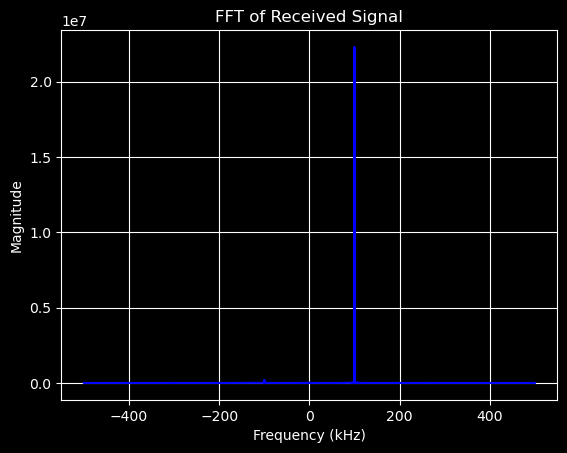

In [10]:
# ---------------------------------------------------------------
# PART 1: Take FFT of received signal.
# ---------------------------------------------------------------
rx_fft = np.abs(np.fft.fftshift(np.fft.fft(rx_signal)))
f = np.linspace(sample_rate/-2, sample_rate/2, len(rx_fft))

%matplotlib inline
plt.figure()
plt.plot(f/1e3,rx_fft,color="blue")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude")
plt.title('FFT of Received Signal')
plt.grid(True)
plt.show()

In [11]:

# ---------------------------------------------------------------
# PART 2: Frequency and Gain Estimation.
# ---------------------------------------------------------------
N_fft = len(rx_signal) * 10
rx_fft = np.abs(np.fft.fftshift(np.fft.fft(rx_signal, N_fft)))
f = np.linspace(sample_rate/-2, sample_rate/2, N_fft)

peak_idx = np.argmax(rx_fft) # find index of peak in FFT output
f0 = f[peak_idx] # frequency of the peak
print(f"Estimated frequency of the received complex exponential (f0): {f0 / 1e3:.5f} kHz")

%matplotlib qt
plt.figure()
plt.plot(f/1e3,rx_fft,color="blue")
plt.xlim([f0 / 1e3 - 1e-1, f0 / 1e3 + 1e-1])  # ENHANCE
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude")
plt.title('FFT of Received Signal')
plt.grid(True)
plt.show()

Estimated frequency of the received complex exponential (f0): 100.00060 kHz


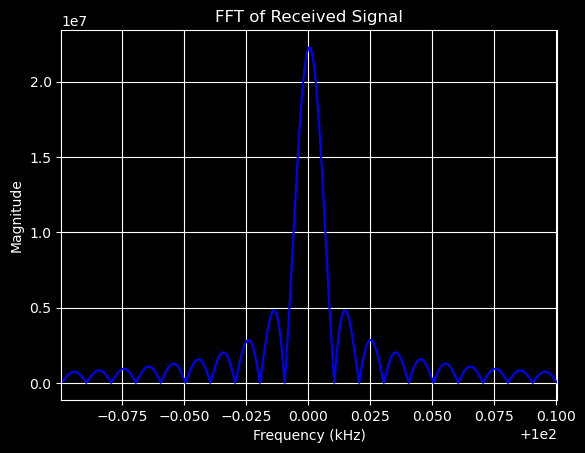

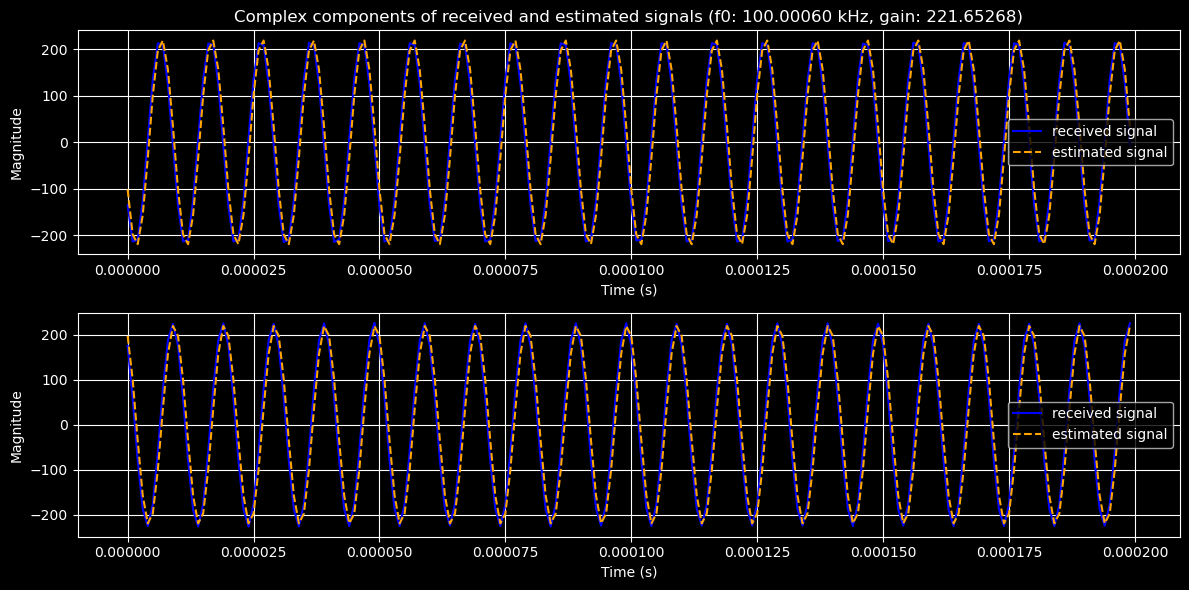

In [12]:
z_est = np.exp(2*1j * np.pi * f0 * (np.arange(rx_buffer_size)/sample_rate))  # Estimated complex exponential
a = np.sum(rx_signal * np.conj(z_est)) / np.sum(np.abs(z_est)**2)  # Gain estimation
z_t = a * z_est

%matplotlib inline
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t[:200], np.real(rx_signal[:200]), label="received signal", color="blue")
plt.plot(t[:200], np.real(z_t[:200]), label="estimated signal", color="orange", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.title(f"Complex components of received and estimated signals (f0: {f0 / 1e3:.5f} kHz, gain: {np.abs(a):.5f})")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t[:200], np.imag(rx_signal[:200]), label="received signal", color="blue")
plt.plot(t[:200], np.imag(z_t[:200]), label="estimated signal", color="orange", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Estimated gain:  (-101.30038946360395+197.15005177838748j)


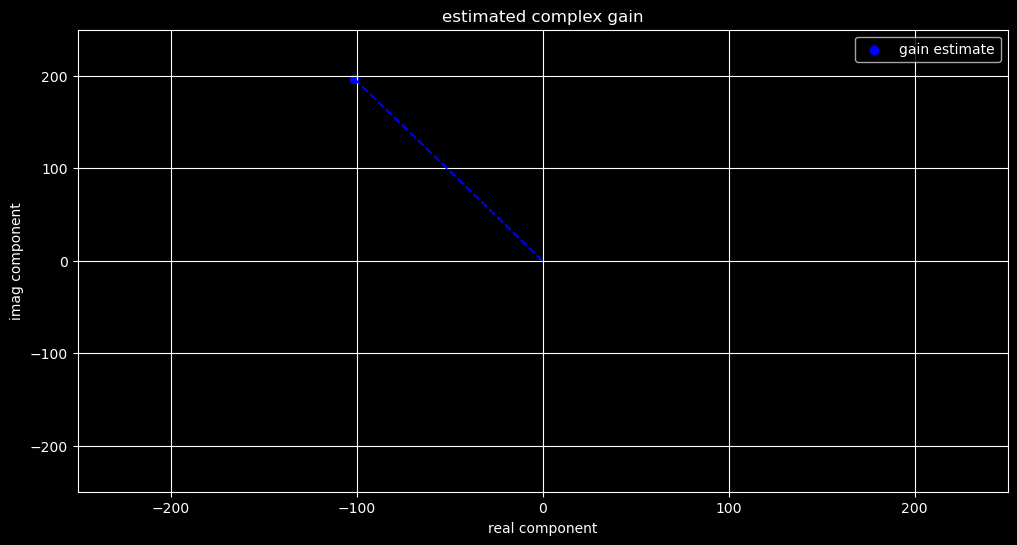

In [13]:
print("Estimated gain: ", a)
plt.figure(figsize=(12, 6))
plt.scatter(np.real(a), np.imag(a), label="gain estimate", color="blue")
plt.plot([0, np.real(a)], [0, np.imag(a)], color="blue", linestyle="dashed")
plt.xlabel("real component")
plt.ylabel("imag component")
plt.xlim([-250, 250])
plt.ylim([-250, 250])
plt.title(f"estimated complex gain")
plt.legend()
plt.grid(True)
plt.show()